# Slippage Analysis

When evaluating a strategy using backtest results, we often want to know how sensitive it's performance is to implementation shortfall or slippage. pyfolio's transactions tear sheet can create "slippage sweep" plots that display strategy performance under various slippage assumptions. 

Additional per-dollar slippage can be applied to returns before running a tear sheet by providing `create_full_tear_sheet` with the a level of slippage in basis points (1% == 100 basis points) as the `slippage` keyword argument. The slippage plots in the transactions tear sheet will display returns with slippage added to the **unadjusted** returns. 

For example, if you run a backtest with no transaction costs and call `create_full_tear_sheet(returns, positions, transactions, slippage=5)`, 5 bps of slippage will be applied to `returns` before all plots and figures, with the exception of the slippage sweep plots, are generated.

It is important to emphasize that the slippage plots will display performance under **additional** slippage. If the passed performance data already has slippage applied, the 5 bps slippage equity curve will represent performance under 5 bps of slippage in addition to the already simulated slippage penalty. If slippage is already applied to the performance results, pass `slippage=0` to the `create_full_tear_sheet` to trigger the creation of the additional slippage sweep plots without applying any additional slippage to the returns time series used throughout the rest of the tear sheet.

## Imports & Settings

In [ ]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

In [1]:
%matplotlib inline
import pyfolio as pf
import gzip
import pandas as pd

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/PyfolioExample/.venv/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


## Load Data

Data already had tz-aware DateTimeIndex set to UTC.

In [2]:
transactions = pd.read_csv(gzip.open('test_data/test_txn.csv.gz'), index_col=0, parse_dates=True)

positions = pd.read_csv(gzip.open('test_data/test_pos.csv.gz'), index_col=0, parse_dates=True)

returns = pd.read_csv(gzip.open('test_data/test_returns.csv.gz'), index_col=0, parse_dates=True, header=None)[1]

In [4]:
returns

0
2004-01-02 00:00:00+00:00    0.000000
2004-01-05 00:00:00+00:00    0.000000
2004-01-06 00:00:00+00:00    0.000000
2004-01-07 00:00:00+00:00    0.000000
2004-01-08 00:00:00+00:00    0.000000
                               ...   
2009-12-24 00:00:00+00:00   -0.001067
2009-12-28 00:00:00+00:00    0.008046
2009-12-29 00:00:00+00:00    0.007204
2009-12-30 00:00:00+00:00    0.002646
2009-12-31 00:00:00+00:00   -0.023011
Name: 1, Length: 1511, dtype: float64

In [5]:
transactions

,amount,price,sid,symbol,txn_dollars
2004-01-09 00:00:00+00:00,448,15.540000,0,AMD,-6961.920000
2004-01-09 00:00:00+00:00,4357,4.823750,1,CERN,-21017.078750
2004-01-09 00:00:00+00:00,241,30.216872,2,COST,-7282.266152
2004-01-09 00:00:00+00:00,618,34.408660,3,DELL,-21264.551880
2004-01-09 00:00:00+00:00,436,16.263945,4,GPS,-7091.080020
...,...,...,...,...,...
2009-12-31 00:00:00+00:00,267,50.033160,2,COST,-13358.853720
2009-12-31 00:00:00+00:00,-2558,13.891150,3,DELL,35533.561700
2009-12-31 00:00:00+00:00,-103,18.685640,4,GPS,1924.620920
2009-12-31 00:00:00+00:00,-1120,16.830877,5,INTC,18850.582240


In [6]:
positions

,AMD,CERN,COST,DELL,GPS,INTC,MMM,cash
index,,,,,,,,
2004-01-09 00:00:00+00:00,6961.92,21017.078750,7282.266152,21264.55188,7091.080020,21259.333890,21316.129606,-6192.360298
2004-01-12 00:00:00+00:00,18198.58,18071.250000,17675.836401,10804.31924,10685.411865,17872.477480,10882.026400,-3329.289887
2004-01-13 00:00:00+00:00,12060.86,11942.246250,12838.477446,16078.90380,16272.139000,12465.392511,12579.135758,4708.039735
2004-01-14 00:00:00+00:00,13102.40,15534.281250,14447.422640,15414.45080,15666.440185,14884.069620,13454.542620,-2749.470030
2004-01-15 00:00:00+00:00,15518.40,14547.050000,14164.039680,14407.48813,14926.122619,14422.385864,13929.159049,-2462.919316
...,...,...,...,...,...,...,...,...
2009-12-24 00:00:00+00:00,-1199.11,1316.857500,22778.660580,-3562.47039,76601.638113,36280.269375,17740.890304,16350.679211
2009-12-28 00:00:00+00:00,589.80,673.840032,24170.422856,-1765.41500,83143.517604,37499.607147,15692.520137,7641.201795
2009-12-29 00:00:00+00:00,292.50,334.920016,20993.396552,858.85252,94500.729990,50509.461877,7946.648597,-6583.290764


/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/PyfolioExample/.venv/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.755%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2004-01-02
End date,2009-12-31
Total months,71
,Backtest
Annual return,8.755%
Cumulative returns,65.404%
Annual volatility,26.251%
Sharpe ratio,0.45
Calmar ratio,0.14
Stability,0.00
Max drawdown,-60.391%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,60.39,2007-11-06,2009-03-09,NaT,NaN
1,24.10,2005-07-28,2006-09-07,2007-05-22,474
2,11.89,2004-06-25,2004-08-12,2004-11-05,96
3,10.87,2004-11-15,2005-04-18,2005-07-14,174
4,9.51,2007-07-16,2007-08-06,2007-09-13,44


/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/PyfolioExample/.venv/lib/python3.10/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/PyfolioExample/.venv/lib/python3.10/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Lehman,-0.27%,-4.70%,4.11%
Aug07,0.32%,-2.96%,2.92%
Mar08,-0.43%,-3.26%,3.36%
Sept08,-0.68%,-4.38%,4.08%
2009Q1,-0.36%,-5.02%,3.39%
2009Q2,0.74%,-4.03%,6.13%
Low Volatility Bull Market,0.01%,-6.07%,6.43%
GFC Crash,-0.09%,-11.76%,10.13%
Recovery,0.35%,-4.03%,6.01%


Top 10 long positions of all time,max
COST,90.01%
DELL,85.73%
CERN,83.53%
MMM,82.09%
INTC,78.59%
AMD,75.76%
GPS,62.24%


Top 10 short positions of all time,max
AMD,-30.12%
DELL,-26.58%
CERN,-25.51%
MMM,-22.62%
GPS,-20.09%
INTC,-18.47%
COST,-16.44%


Top 10 positions of all time,max
COST,90.01%
DELL,85.73%
CERN,83.53%
MMM,82.09%
INTC,78.59%
AMD,75.76%
GPS,62.24%


/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/PyfolioExample/.venv/lib/python3.10/site-packages/pyfolio/pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/PyfolioExample/.venv/lib/python3.10/site-packages/pyfolio/pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/PyfolioExample/.venv/lib/python3.10/site-packages/pyfolio/plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/

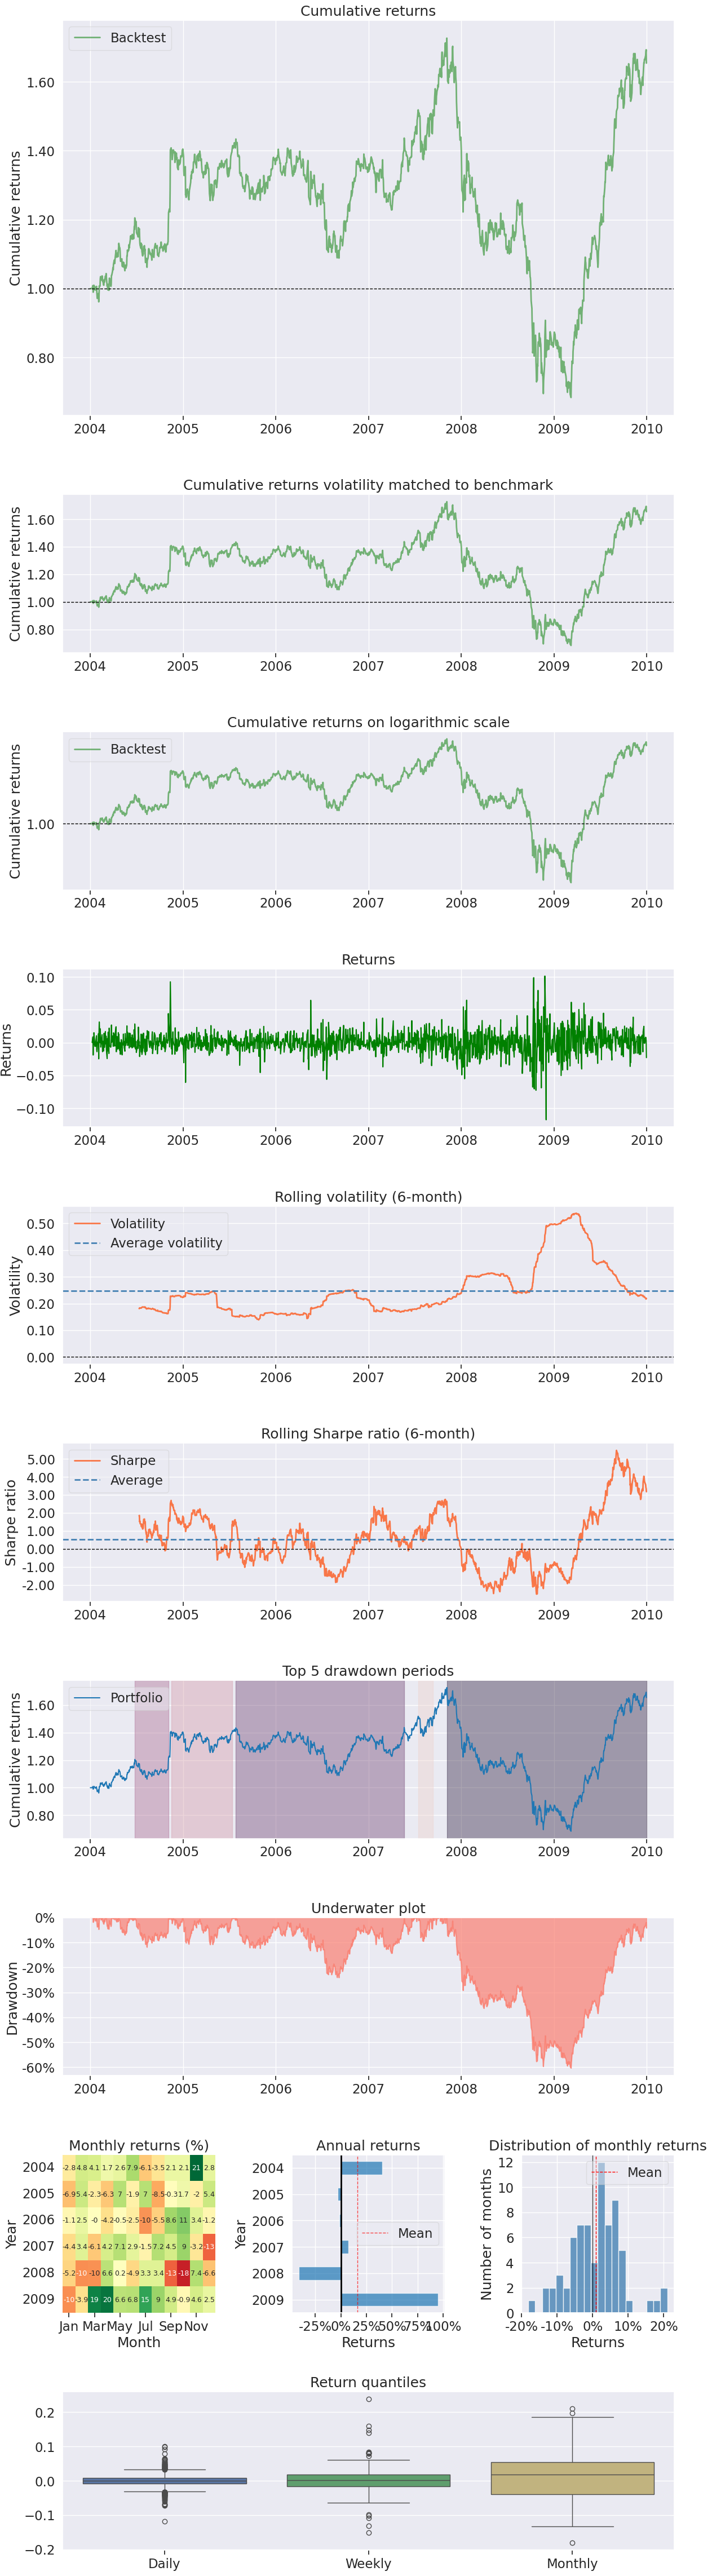

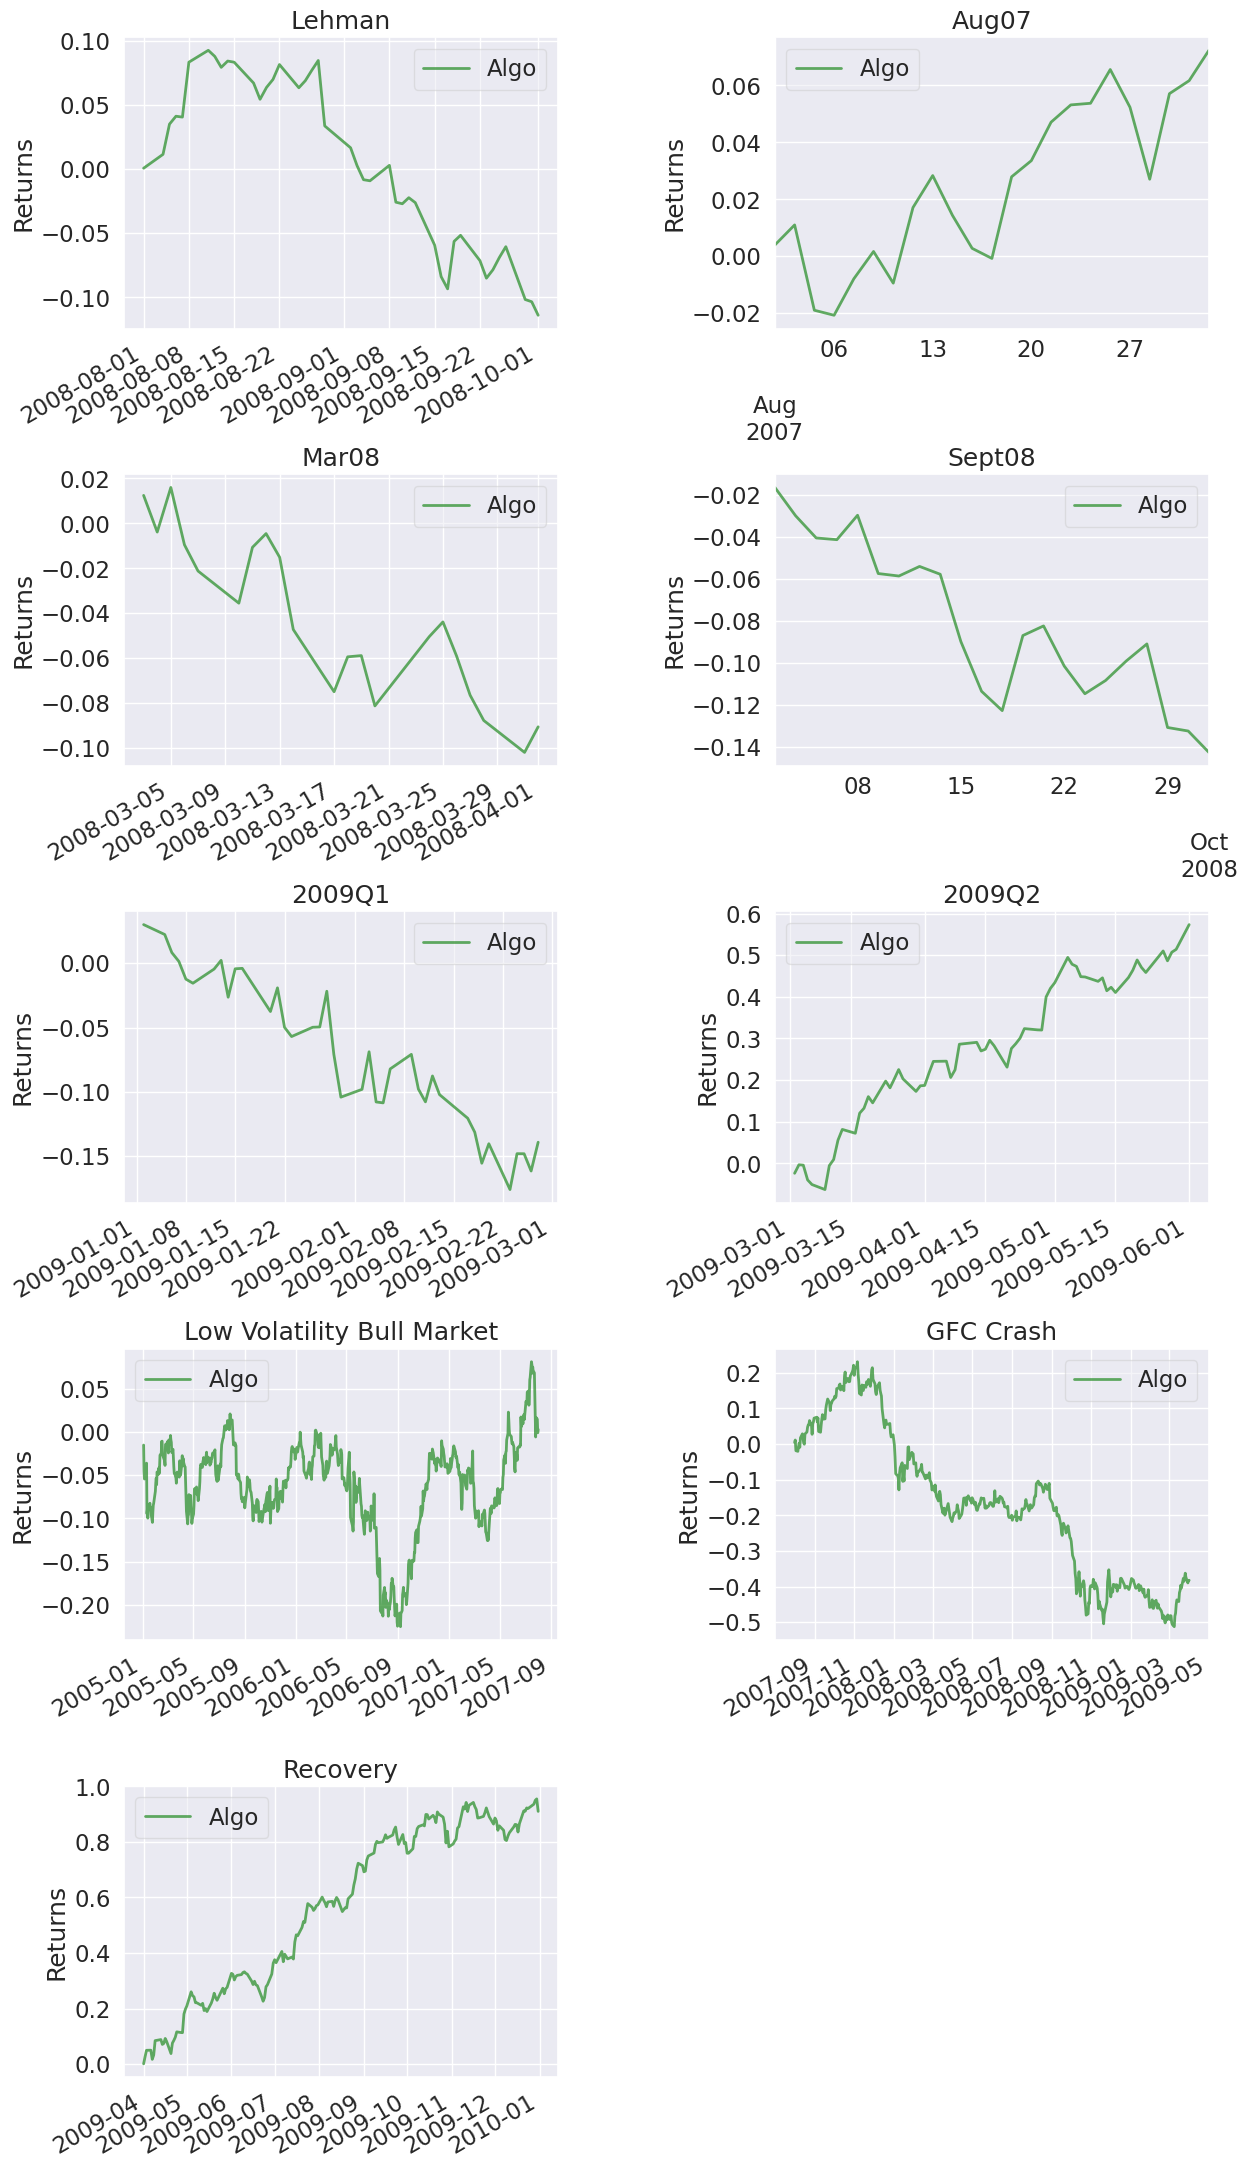

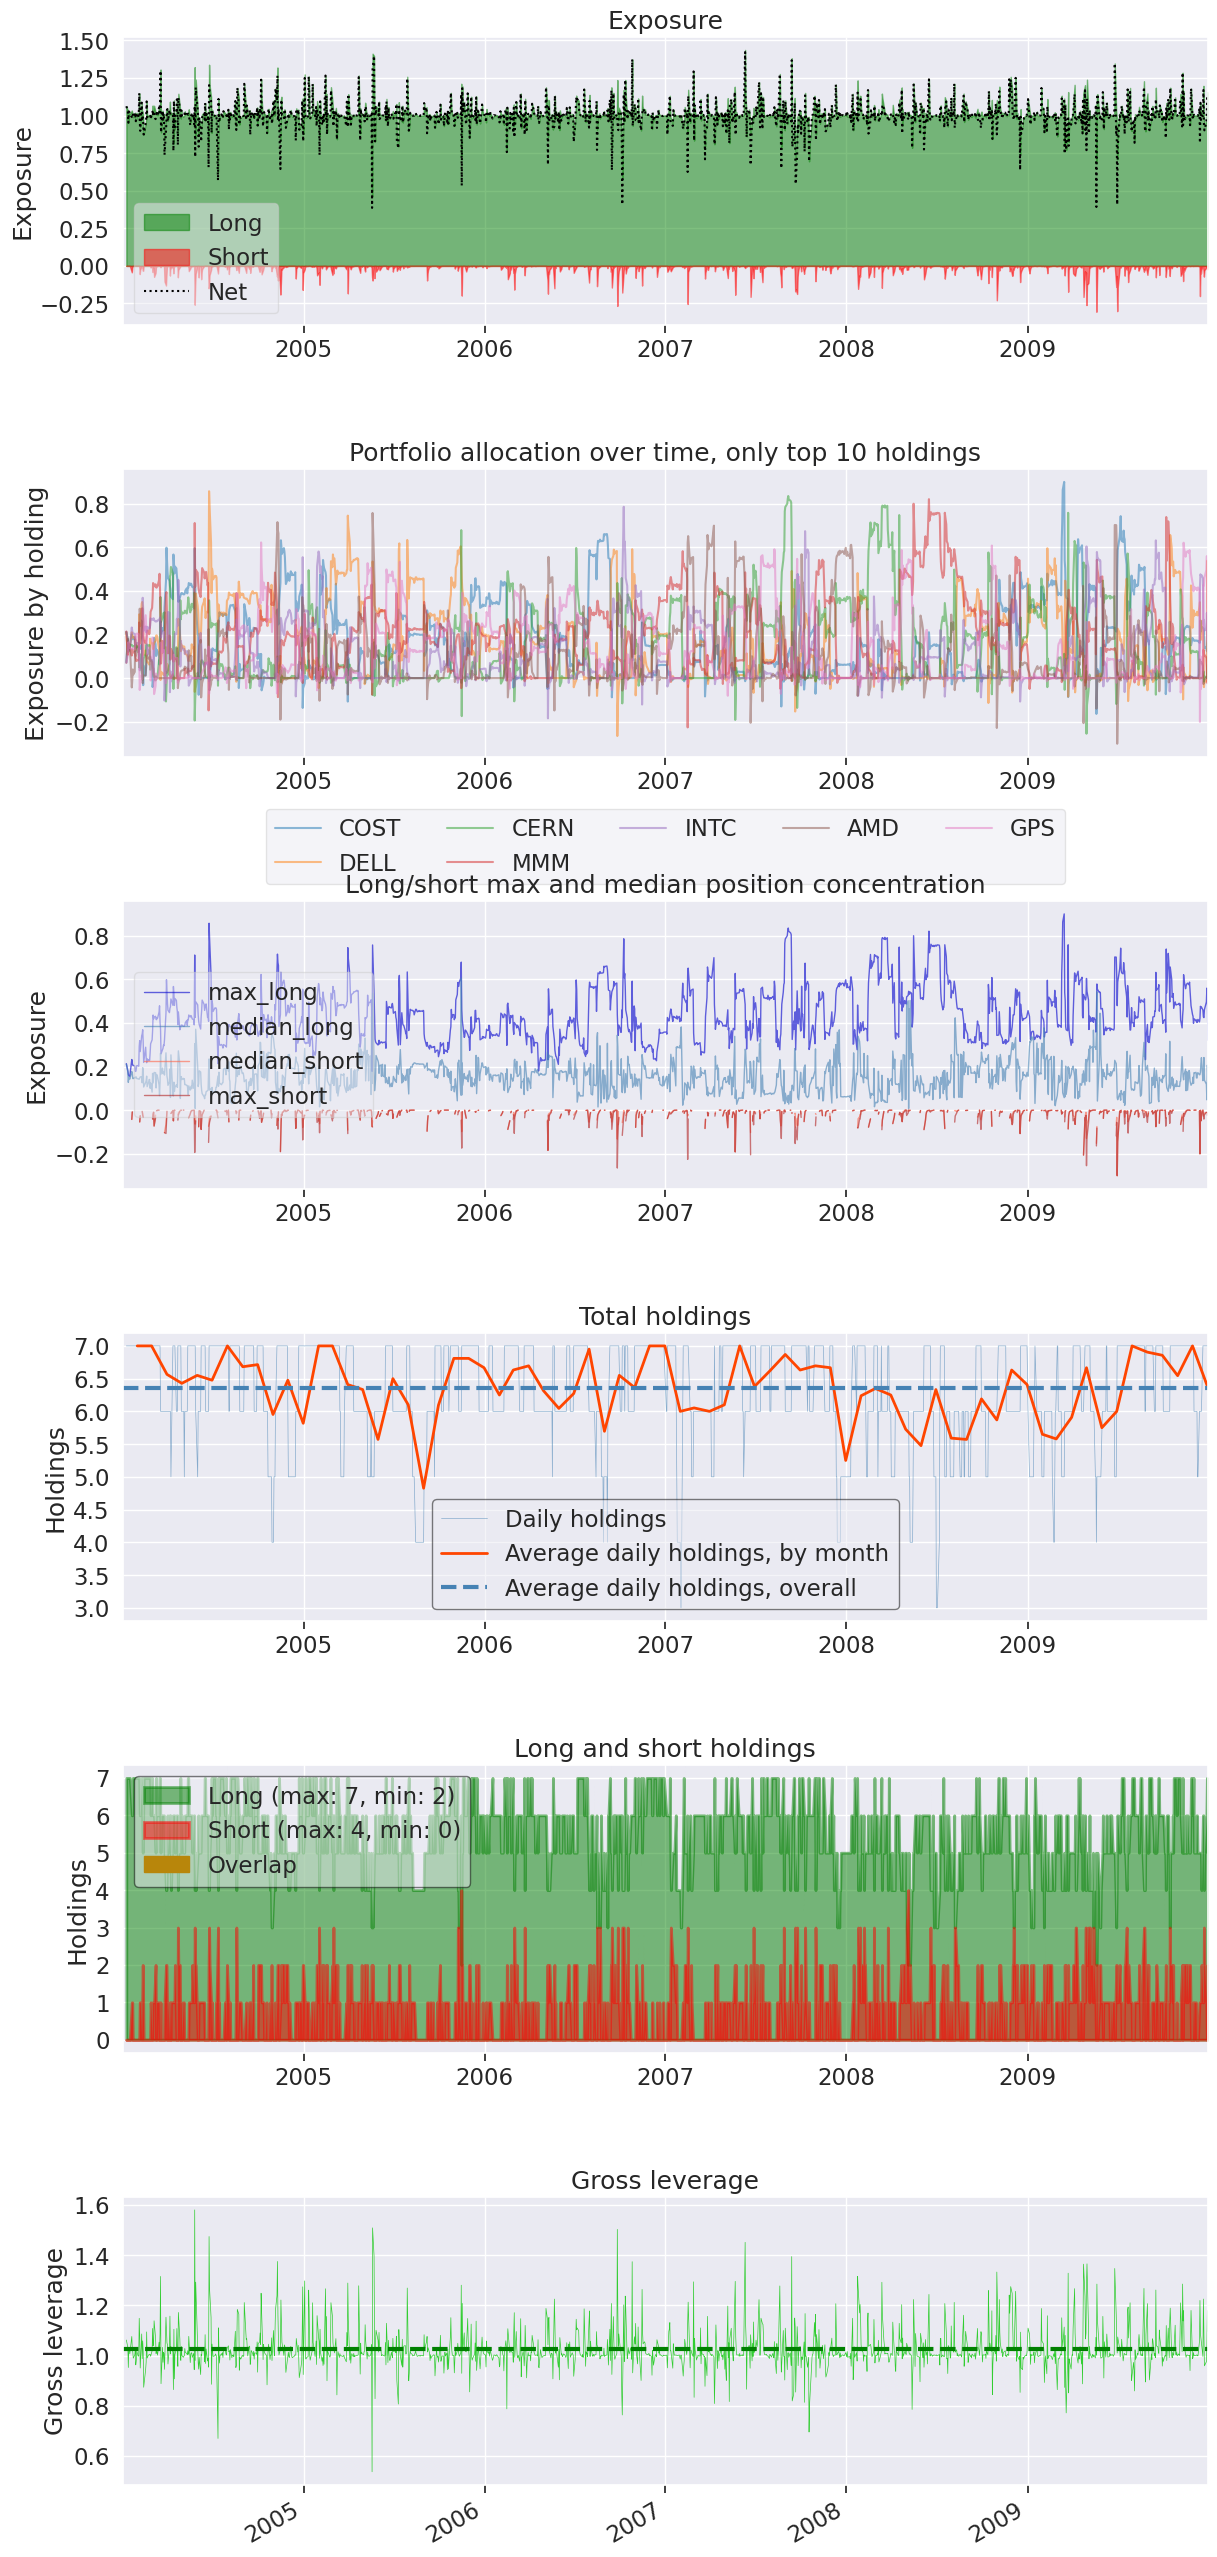

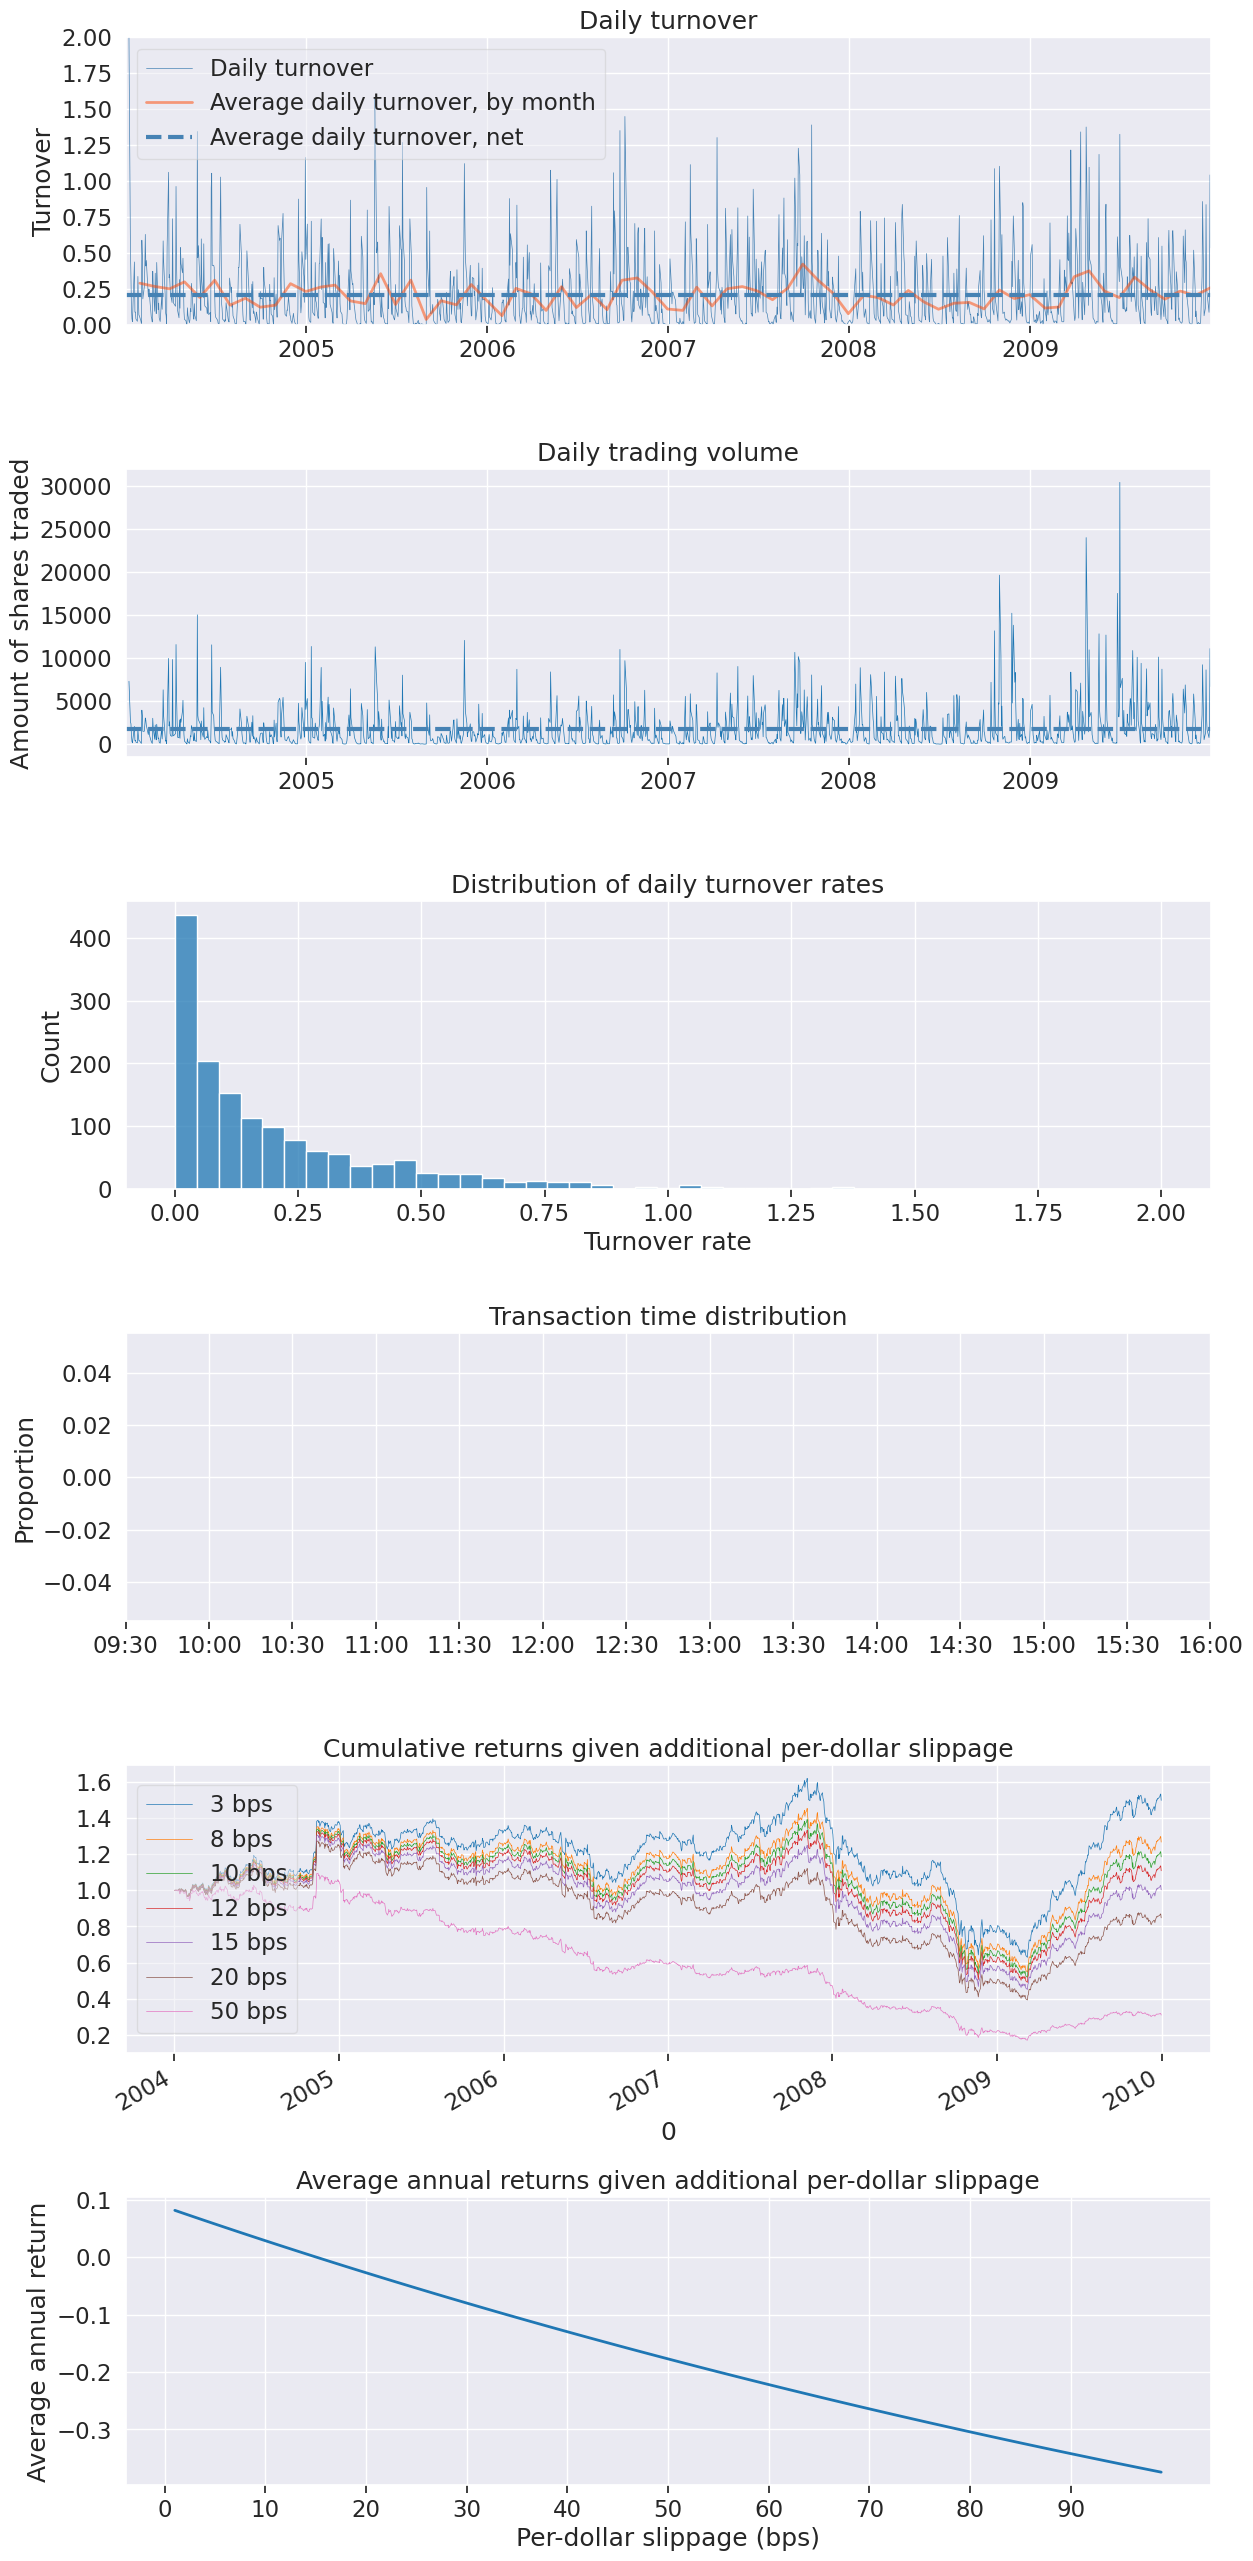

In [3]:
pf.create_full_tear_sheet(returns, positions, transactions, slippage=0)